# Training Btagging model for L1 Trigger

In [1]:
# Standard Stuff
import h5py
import tempfile
import numpy as np
from numpy import expand_dims

from keras.models import load_model

# Qkeras
from qkeras.quantizers import quantized_bits, quantized_relu
from qkeras.qlayers import QDense, QActivation
from qkeras import QConv1D

#Tensorflow
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

#Tensorflow Model Optimization
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

2023-06-19 05:02:18.301253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load the data

In [2]:
######------------------ LOAD DATA ------------------######
with h5py.File('../data/trainingDataTT_PUP_Pad150.h5', 'r') as hf:
    dataset = hf["Training Data"][:]

# Import jet data used to pT based sample weights
with h5py.File('../data/sampleDataTT_PUP_Pad150.h5', 'r') as hf:
    sampleData = hf["Sample Data"][:]

# Split datasets into inputs & outputs
X = dataset[:, 0:len(dataset[0])-1]
y = dataset[:, len(dataset[0])-1]

# Expand to be usable for Conv1D
X = expand_dims(X, axis=2)

# Establish bins and peform pT based sample weights
thebins = np.linspace(0, 360, 180)

bkgPts = []
sigPts = []
for i in range(len(sampleData)):
    if y[i] == 1:
        sigPts.append(sampleData[i][0])
    if y[i] == 0:
        bkgPts.append(sampleData[i][0])

bkg_counts, binsbkg = np.histogram(bkgPts, bins=thebins)
sig_counts, binssig = np.histogram(sigPts, bins=thebins)

a = []
for i in range(len(bkg_counts)):
    tempSig = float(sig_counts[i])
    tempBkg = float(bkg_counts[i])
    if tempBkg != 0:
        a.append(tempSig/tempBkg)
    if tempBkg == 0:
        a.append(0)

# Normalize sample weights at higher pTs
for i in range(50, len(a)):
    a[i] = 0.6

# Create weights in 1-to-1 ratio with training data
weights = []
for i in range(len(sampleData)):
    if y[i] == 1:
        weights.append(1)
    if y[i] == 0:
        jetPt = sampleData[i][0]
        tempPt = int(jetPt/2)
        if tempPt > 178:
            tempPt = 178
        weights.append(a[tempPt])

# Train model

In [3]:
#####------------------ MODEL TRAINING ------------------#####
bits = 9
bits_int = 2
alpha_val = 1
bits_conv = 9

model = tf.keras.Sequential()

model.add(QConv1D(filters=20, kernel_size=15, strides=15, name='Conv1D_1',
                  kernel_quantizer=quantized_bits(
                      bits_conv, bits_int, alpha=alpha_val),
                  bias_quantizer=quantized_bits(
                      bits_conv, bits_int, alpha=alpha_val),
                  # kernel_regularizer=l1(0.0001),
                  kernel_initializer='lecun_uniform',
                  input_shape=(len(dataset[0])-1, 1)))

model.add(QActivation(activation=quantized_relu(bits), name='relu_1'))

model.add(QConv1D(filters=5, kernel_size=1, name='Conv1D_2',
                  kernel_quantizer=quantized_bits(
                      bits_conv, bits_int, alpha=alpha_val),
                  bias_quantizer=quantized_bits(
                      bits_conv, bits_int, alpha=alpha_val),
                  kernel_initializer='lecun_uniform'))  # , kernel_regularizer=l1(0.0001)))

model.add(QActivation(activation=quantized_relu(bits), name='relu_2'))

model.add(tf.keras.layers.Flatten())
model.add(QDense(20, name='Dense_1',
                 kernel_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 bias_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 kernel_initializer='lecun_uniform'))  # , kernel_regularizer=l1(0.0001)))

model.add(QActivation(activation=quantized_relu(bits), name='relu_3'))

model.add(QDense(10, name='Dense_2',
                 kernel_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 bias_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 kernel_initializer='lecun_uniform'))  # , kernel_regularizer=l1(0.0001)))

model.add(QActivation(activation=quantized_relu(bits), name='relu_4'))

model.add(QDense(1, name='output',
                 kernel_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 bias_quantizer=quantized_bits(
                     bits, bits_int, alpha=alpha_val),
                 kernel_initializer='lecun_uniform'))  # , kernel_regularizer=l1(0.0001)))

model.add(tf.keras.layers.Activation(activation='sigmoid', name='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['binary_accuracy'])

print(model.summary())

2023-06-19 05:02:20.896512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1D_1 (QConv1D)          (None, 10, 20)            320       
                                                                 
 relu_1 (QActivation)        (None, 10, 20)            0         
                                                                 
 Conv1D_2 (QConv1D)          (None, 10, 5)             105       
                                                                 
 relu_2 (QActivation)        (None, 10, 5)             0         
                                                                 
 flatten (Flatten)           (None, 50)                0         
                                                     

In [4]:
batch_size = 1024
epochs = 100
validation_split = 0.1 # 10% of training set will be used for validation set. 

# sparsity parameters
i_sparsity = 0.2
f_sparsity = 0.7

num_samples = X.shape[0] * (1 - validation_split)
end_step = np.ceil(num_samples / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=i_sparsity,
                                                               final_sparsity=f_sparsity,
                                                               begin_step=0,
                                                               end_step=end_step)
}

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_for_pruning = prune_low_magnitude(model, **pruning_params)

In [5]:
# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model_for_pruning.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_Conv1D_  (None, 10, 20)           622       
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_relu_1   (None, 10, 20)           1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_Conv1D_  (None, 10, 5)            207       
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_relu_2   (None, 10, 5)            1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_flatten  (None, 50)               1

In [6]:
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=2, patience=5)
]

model_for_pruning.fit(X, y,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

Epoch 1/100


/data/dhoang/miniforge3/envs/btag_L1/lib/python3.8/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


298/298 [==============================] - 8s 15ms/step - loss: 0.5860 - accuracy: 0.6824 - val_loss: 0.5492 - val_accuracy: 0.6889
Epoch 2/100
298/298 [==============================] - 4s 14ms/step - loss: 0.5411 - accuracy: 0.7030 - val_loss: 0.5314 - val_accuracy: 0.7178
Epoch 3/100
298/298 [==============================] - 4s 14ms/step - loss: 0.5283 - accuracy: 0.7197 - val_loss: 0.5233 - val_accuracy: 0.7266
Epoch 4/100
298/298 [==============================] - 4s 13ms/step - loss: 0.5199 - accuracy: 0.7293 - val_loss: 0.5149 - val_accuracy: 0.7340
Epoch 5/100
298/298 [==============================] - 4s 14ms/step - loss: 0.5151 - accuracy: 0.7346 - val_loss: 0.5122 - val_accuracy: 0.7375
Epoch 6/100
298/298 [==============================] - 4s 14ms/step - loss: 0.5125 - accuracy: 0.7379 - val_loss: 0.5092 - val_accuracy: 0.7393
Epoch 7/100
298/298 [==============================] - 4s 14ms/step - loss: 0.5096 - accuracy: 0.7403 - val_loss: 0.5098 - val_accuracy: 0.7393
Epoc

In [7]:
# Save model
model_path = 'models/pruned_{}_quant_{}bit.h5'.format(f_sparsity, bits)
model.save(model_path)

# ROC curve

In [8]:
#Load the data
with h5py.File('../data/testingDataTT_PUP_Pad150.h5', 'r') as hf:
    dataset = hf["Testing Data"][:]

A = dataset[:,0:len(dataset[0])-1]
b = dataset[:,len(dataset[0])-1]

A = expand_dims(A,axis=2)

4530/4530 [==============================] - 6s 1ms/step


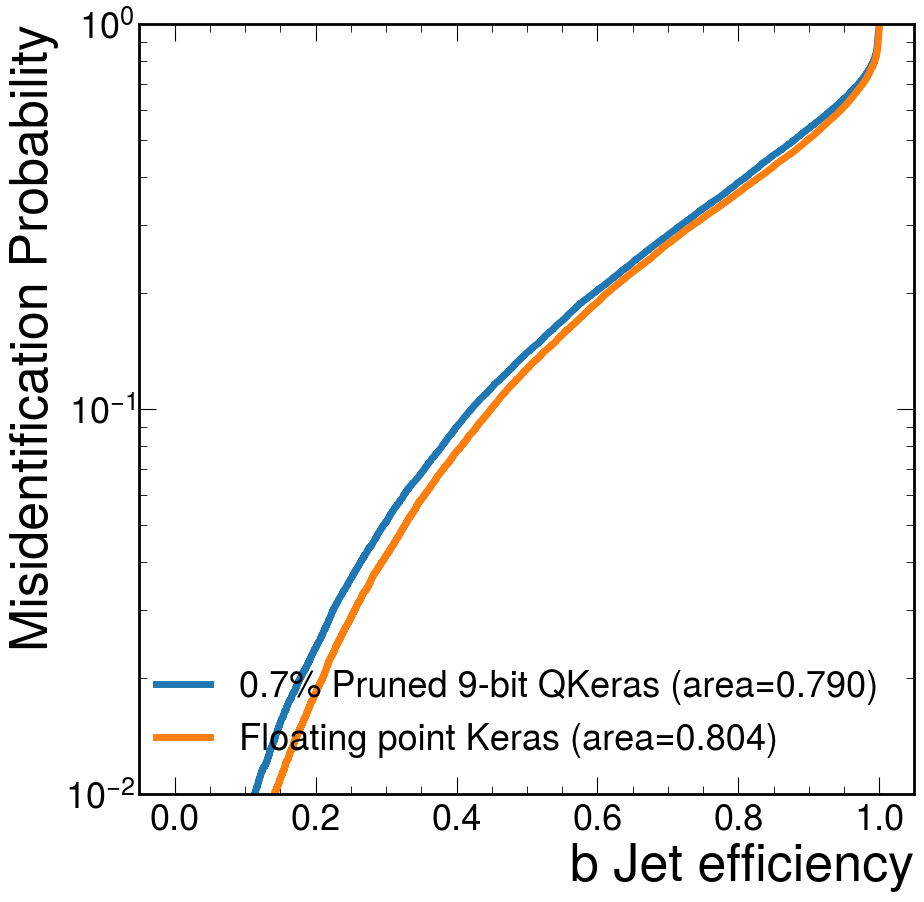

In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Ab_pred_keras = model.predict(A).ravel()
fpr_Ab, tpr_Ab, thresholds_Ab = roc_curve(b,Ab_pred_keras)
auc_Ab = auc(fpr_Ab,tpr_Ab)

full_model = load_model('models/FullBitModel.h5')
full_pred_keras = full_model.predict(A).ravel()
fpr_full, tpr_full, thresholds_full = roc_curve(b,full_pred_keras)
auc_full = auc(fpr_full, tpr_full)

#Just plot
plt.plot(tpr_Ab,fpr_Ab,label='{}% Pruned {}-bit QKeras (area={:.3f})'.format(f_sparsity, bits,auc_Ab))
plt.plot(tpr_full,fpr_full,label='Floating point Keras (area={:.3f})'.format(auc_full))

#Other plotting parameters
plt.xlabel('b Jet efficiency')
plt.ylabel('Misidentification Probability')
plt.yscale('log')
plt.ylim([10**(-2),1])
plt.legend(loc='lower right')
plt.savefig('Models_ROC.png')